In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Union

import candle
import candle.functions as F
import experiments.trainingutils as tutils

## (1) Load data

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()

X = digits.images.reshape((len(digits.images), -1))  # Flatten the images

X_train, X_test, y_train, y_test = train_test_split(  # Split data into 50% train and 50% test subsets
    X, digits.target, test_size=0.5, shuffle=False
)

# Standardize data

train_mean = X_train.mean()
train_std = X_train.std()
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

num_features = X_train.shape[1]
num_classes = len(set(y_train.data))

In [4]:
X_train = candle.Tensor(X_train)
y_train = candle.Tensor(y_train)
X_test = candle.Tensor(X_test)
y_test = candle.Tensor(y_test)

X_train.shape, y_train.shape

((898, 64), (898,))

## (2) Define Training Configuration

In [5]:
class Config:
    # General configs
    
    ITERATIONS = 2000
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-2
    WEIGHT_DECAY = 1e-2
    
    EVAL_ITERS = 1
    EVAL_BATCH_SIZE = 64
    DASHBOARD_REFRESH_ITERS = 100
    
    # Model-specific configs
    
    NUM_LAYERS = 4
    HIDDEN_DIM = 64
    
    
config = Config()

## (3) Define Model

In [6]:
class MLP(candle.Module):
    
    def __init__(self,
                 input_size: int,
                 hidden_sizes: List[int]):
        super().__init__()
        
        self.linear_layers = candle.ParameterList([
            candle.Linear(i, j)
            for (i, j) in zip([input_size] + hidden_sizes, hidden_sizes)
        ])
        
        
    def forward(self, x):
        for linear_layer in self.linear_layers[:-1]:
            x = linear_layer(x)
            x = F.relu(x)
            
        x = self.linear_layers[-1](x)
            
        return x      

In [7]:
model = MLP(input_size=num_features,
            hidden_sizes=[config.HIDDEN_DIM] * (config.NUM_LAYERS - 1) + [num_classes])

optimizer = candle.optimizer.SGD(model.parameters(),
                                 learning_rate=config.LEARNING_RATE,
                                 weight_decay=config.WEIGHT_DECAY)

model.summary(input_shape=(128, 64))

,Layer Type,# Parameters,Output Shape
linear_layers.0,Linear,4160,"(128, 64)"
linear_layers.1,Linear,4160,"(128, 64)"
linear_layers.2,Linear,4160,"(128, 64)"
linear_layers.3,Linear,650,"(128, 10)"
Total,,13130,


## (4) Check Activations and Gradients at Initialization

In [8]:
# Register forward hooks to facilitate activation logging

layer_activations = {}
def store_activations(layer_name):
    def hook_fn(module, input, output):
        layer_activations[layer_name] = output
    
    return hook_fn


def get_activations():
    act_by_layer = {layer_name: layer_activations[layer_name].data.flatten() for layer_name in layer_activations}
    activations = np.concatenate(list(act_by_layer.values()))
    act_norm_by_layer = {layer_name: np.linalg.norm(act) for (layer_name, act) in act_by_layer.items()}
    act_rmsnorm_by_layer = {name: np.sqrt(np.mean(np.square(act_by_layer[name]))) for name in act_by_layer}
    
    return (activations, act_by_layer, act_norm_by_layer, act_rmsnorm_by_layer)


params_to_track = [f'linear_layers.{i}.W' for i in range(len(model.linear_layers))]

for (i, layer) in enumerate(model.linear_layers):
    layer.register_forward_hook(store_activations(f'linear_layers.{i}'))    

In [9]:
X_batch = X_train[:256]
y_batch = y_train[:256]

output = model(X_batch)
loss = F.cross_entropy_loss(output, y_batch)
loss.backward()

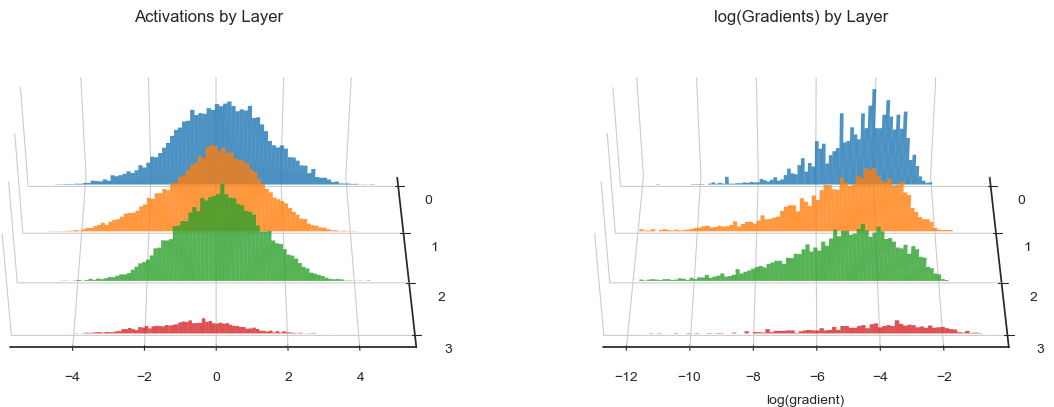

In [10]:
writer = candle.Dashboard()
writer.change_settings('xlim', (-12, np.inf), chart_label='log(Gradients) by Layer')
writer.change_settings('hist_xlabel', 'log(gradient)', chart_label='log(Gradients) by Layer')

for layer_name in layer_activations:
    writer.add_histogram('Activations by Layer', layer_activations[layer_name].data.flatten())

for layer in model.linear_layers:
    gradients = layer.W.grad.flatten()
    writer.add_histogram('log(Gradients) by Layer', np.log(np.abs(gradients) + 1e-10))

writer.plot()

## (5) Train Model

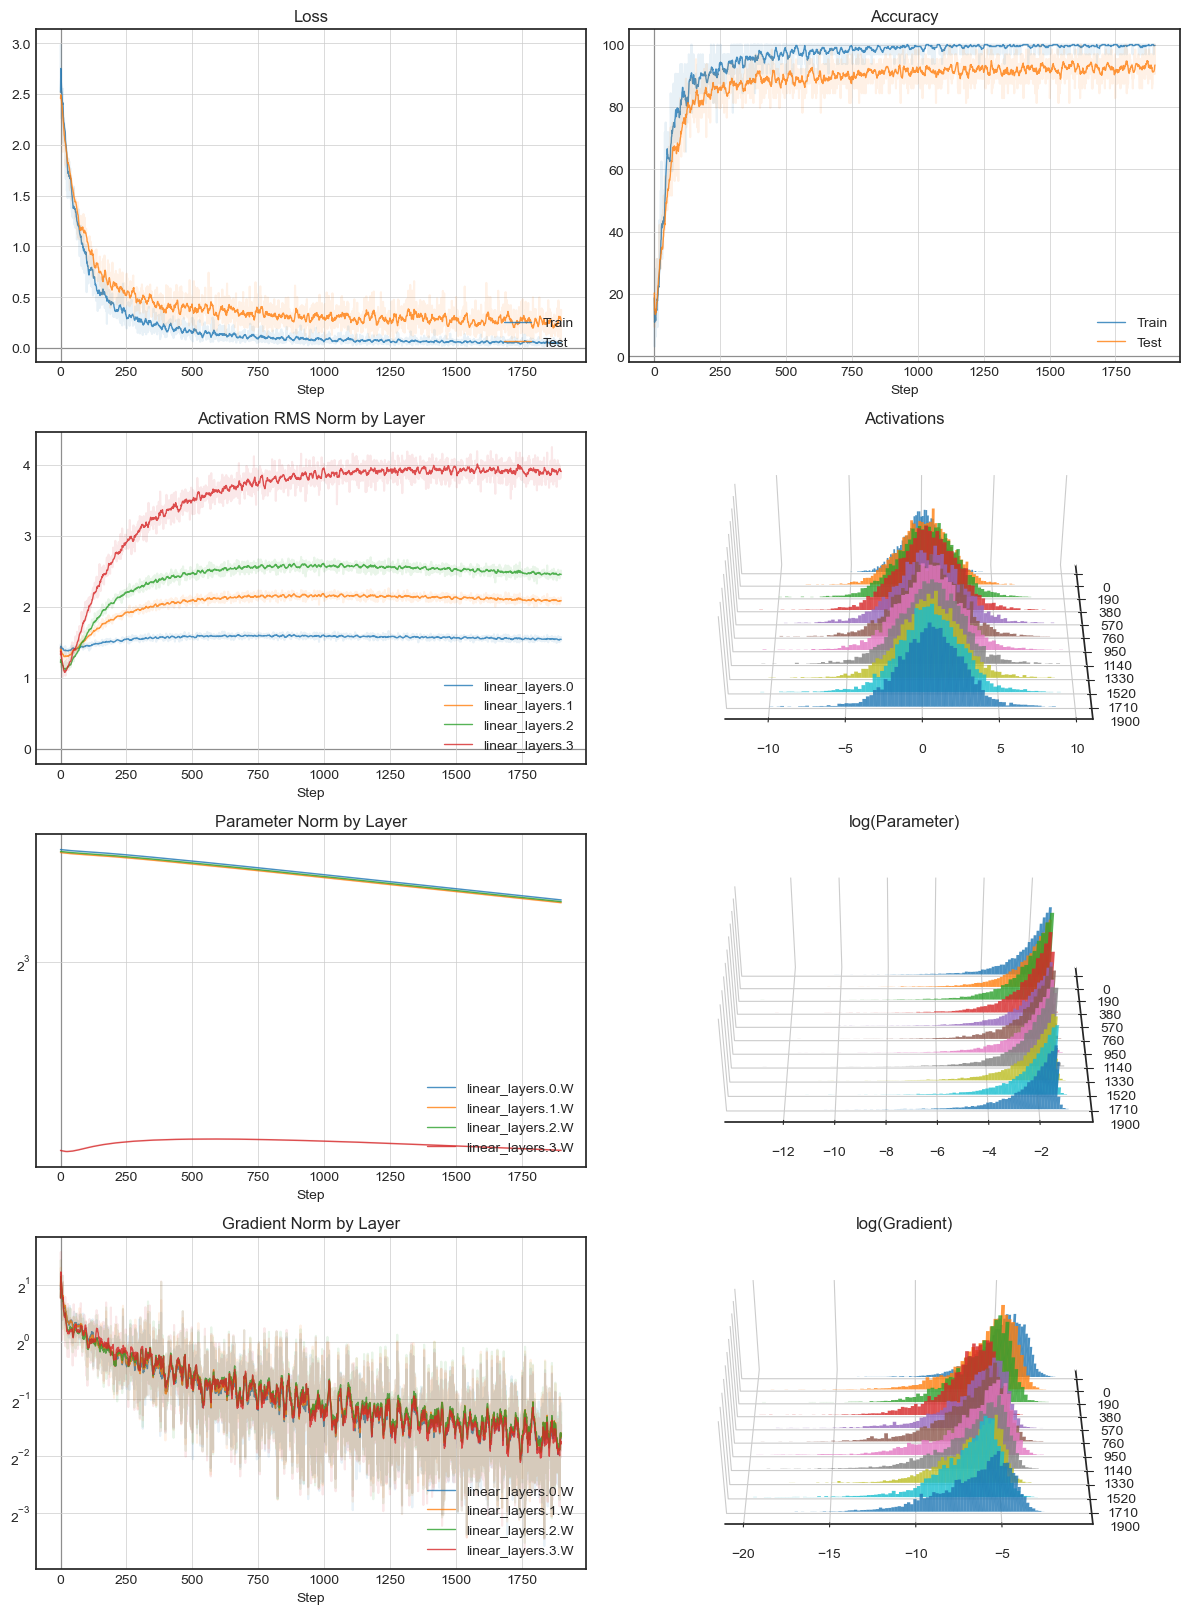

In [11]:
writer = candle.Dashboard()
writer.change_settings('xlim', (-20, np.inf), chart_label='log(Gradient)')
writer.change_settings('xlim', (-20, np.inf), chart_label='log(Parameter)')
writer.change_settings('yscale', 'log', chart_label='Parameter Norm by Layer')
writer.change_settings('yscale', 'log', chart_label='Gradient Norm by Layer')

data_loader = candle.DataLoader(X_train, y_train, batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True)
data_iterator = iter(data_loader)

for iteration in range(config.ITERATIONS):
    
    model.train()

    try:
        (X_batch, y_batch) = next(data_iterator)
    except StopIteration:
        data_iterator = iter(data_loader)
        (X_batch, y_batch) = next(data_iterator)

    output = model(X_batch)
    loss = F.cross_entropy_loss(output, y_batch)
    loss.backward()
    
    optimizer.step()

    # -----------------
    # Visualize metrics
    # -----------------

    model.eval()
    
    (activations, act_by_layer, act_norm_by_layer, act_rmsnorm_by_layer) = get_activations()
    (parameters, param_by_layer, param_norm_by_layer) = tutils.get_parameters(params_to_track, model)
    (gradients, grad_by_layer, grad_norm_by_layer) = tutils.get_gradients(params_to_track, model)
    
    (train_loss, train_acc) = tutils.get_loss_and_accuracy(model, X_batch, y_batch, output.data)
    writer.add_scalars('Loss', {'Train': train_loss})
    writer.add_scalars('Accuracy', {'Train': train_acc})

    if iteration % config.EVAL_ITERS == 0:
        test_batch = tutils.get_random_batch(X_test, y_test, batch_size=config.EVAL_BATCH_SIZE)
        (test_loss, test_acc) = tutils.get_loss_and_accuracy(model, *test_batch)
        writer.add_scalars('Loss', {'Test': test_loss}, iteration)
        writer.add_scalars('Accuracy', {'Test': test_acc}, iteration)
    
    writer.add_scalars('Activation RMS Norm by Layer', act_rmsnorm_by_layer)
    writer.add_histogram('Activations', activations)
    
    writer.add_scalars('Parameter Norm by Layer', param_norm_by_layer)
    writer.add_histogram('log(Parameter)', np.log(np.abs(parameters) + 1e-10))
    
    writer.add_scalars('Gradient Norm by Layer', grad_norm_by_layer)
    writer.add_histogram('log(Gradient)', np.log(np.abs(gradients) + 1e-10))
        
    if iteration % config.DASHBOARD_REFRESH_ITERS == 0:
        writer.plot(clear_output=True)

## (6) Visualize Predictions

Final Test Accuracy: 92.44%


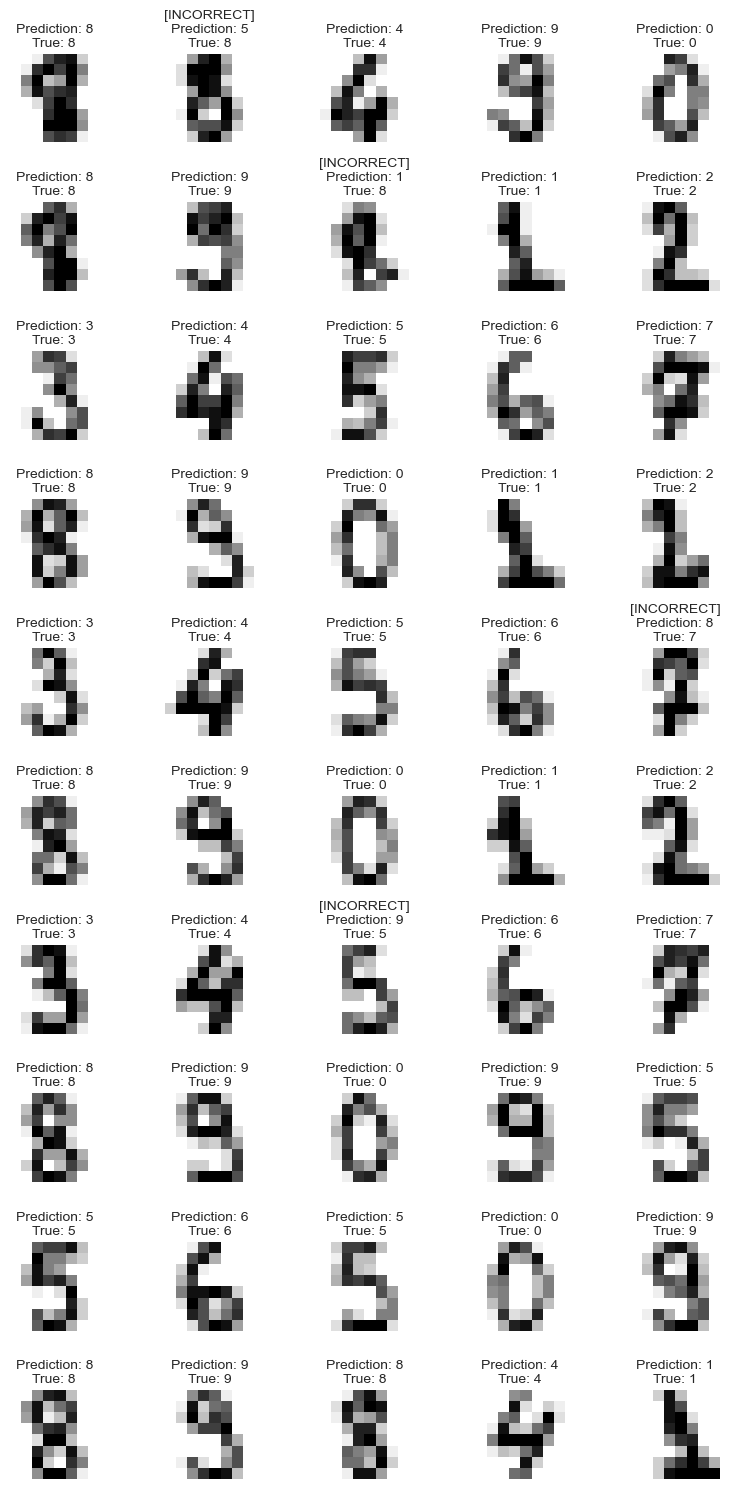

In [12]:
predictions = tutils.get_predictions(model, X_test)
(test_loss, test_acc) = tutils.get_loss_and_accuracy(model, X_test, y_test)
print(f'Final Test Accuracy: {test_acc:.2f}%')

(fig, axes) = plt.subplots(nrows=10, ncols=5, figsize=(8, 3*5))
axes = axes.flatten()
for (ax, image, prediction, label) in zip(axes, X_test.data, predictions, y_test.data):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    wrong_label = '[INCORRECT]\n' if prediction != label else ''
    ax.set_title(f'{wrong_label}Prediction: {prediction}\nTrue: {label}', fontsize=10)
    
plt.tight_layout()
plt.show()